In [1]:
#  Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

You have 2 options here:

Automatic setup: By runnning the code cells below all the necessay files will be downloaded at once and will be ready to use.
Manual Setup: In this case, you'll have to download and perform the required setup manually.
Instructions for Manual Setup
Download Model files from Tensorflow model ZOO
Model files can be downloaded from the Tensorflow Object Detection Model Zoo: tf2_detection_zoo.md

Download mobilenet model file
You can download the model TAR.GZ file and uncompress it.

After Uncompressing and put the highlighed file (along with the folder) in a models folder.

ssd_mobilenet_v2_coco_2018_03_29
|─ checkpoint
|─ frozen_inference_graph.pb
|─ model.ckpt.data-00000-of-00001
|─ model.ckpt.index
|─ model.ckpt.meta
|─ pipeline.config
|─ saved_model
|─── saved_model.pb
|─── variables

Create config file from frozen graph
Extract the files
Run the tf_text_graph_ssd.py file with input as the path to the frozen_graph.pb file and output as desired.
A sample config file has been included in the models folder

A Script to download and extract model tar.gz file.

In [7]:
if not os.path.isdir('models'):
    os.mkdir("models")

if not os.path.isdir('models/ssd_mobilenet_v2_coco_2018_03_29'):
    os.chdir("models")
    # Download the tensorflow Model
    urlretrieve('http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz', 'ssd_mobilenet_v2_coco_2018_03_29.tar.gz')

    # Uncompress the file
    !tar -xvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

    # Delete the tar.gz file
    os.remove('ssd_mobilenet_v2_coco_2018_03_29.tar.gz')

    # Come back to the previous directory
    os.chdir("..")

In [8]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)


In [9]:
URL = r"https://www.dropbox.com/s/xoomeq2ids9551y/opencv_bootcamp_assets_NB13.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB13.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)  

In [10]:
classFile = "coco_class_labels.txt"

with open(classFile) as fp:
    labels = fp.read().split("\n")
    #what is the use of split here? Because the file is already in the form of a list and we are splitting it again? Because the file is in the form of a string and we are splitting it into a list of strings
print(labels)

['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush', '']


The steps for performing infernece using a DNN model are summarized below:

Load the model and input image into memory.
Detect objects using a forward pass through the network.
Display the detected objects with bounding boxes and class labels.
Read Tensorflow Model

In [11]:
modelFile = os.path.join("models","ssd_mobilenet_v2_coco_2018_03_29","frozen_inference_graph.pb")
configFile = os.path.join("models","ssd_mobilenet_v2_coco_2018_03_29.pbtxt")

#Read the Tensorflow model
net = cv2.dnn.readNetFromTensorflow(modelFile,configFile)

In [12]:
#for each file in the folder
def detect_objects(net,img):
    dim = 300 #Why 300? Because the model was trained on 300x300 images
    #Create a blob from the image
    blob = cv2.dnn.blobFromImage(img,1.0,(dim,dim),mean=(0,0,0),swapRB=True,crop=False)
    
    #pass the blob through the network
    net.setInput(blob)
    
    #Perform the detection
    objects = net.forward()
    
    return objects

In [26]:
def display_text(img,text,x,y):
    
    #Get the size of the text to display
    textSize = cv2.getTextSize(text,cv2.FONT_HERSHEY_PLAIN,fontScale=1.5,thickness=2)
    dim = textSize[0]
    baseline  = textSize[1]
    
    #Use text size to create a black rectangle
    cv2.rectangle(img,(x,y-dim[1]-baseline),(x+dim[0],y+baseline),(0,0,0),cv2.FILLED)
    
    #Display the text inside the rectangle
    cv2.putText(img,text,(x,y-5),cv2.FONT_HERSHEY_PLAIN,fontScale=0.7,color=(0,255,0),thickness=1)

In [27]:
#display the objects
def display_objects(img,objects,threshold=0.25):
    #threshold is the minimum confidence level for the object to be detected
    rows = img.shape[0]; cols = img.shape[1]
    
    #For every object detected
    for i in range(objects.shape[2]):
        #Find the class index
        classId = int(objects[0,0,i,1])
        #find the confidence level
        score = float(objects[0,0,i,2])
        
        #Recovers the original coordinates of the detected object
        x = int(objects[0,0,i,3]*cols)
        y = int(objects[0,0,i,4]*rows)
        w = int(objects[0,0,i,5]*cols-x)
        h = int(objects[0,0,i,6]*rows-y)
        
        #Filter out weak detections by ensuring the confidence level is greater than the threshold
        if score > threshold:
            display_text(img,"{}".format(labels[classId]),x,y)
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),thickness=2)
    
    #Convert the image from BGR to RGB
    mp_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30,10));plt.imshow(mp_img);plt.show()
       

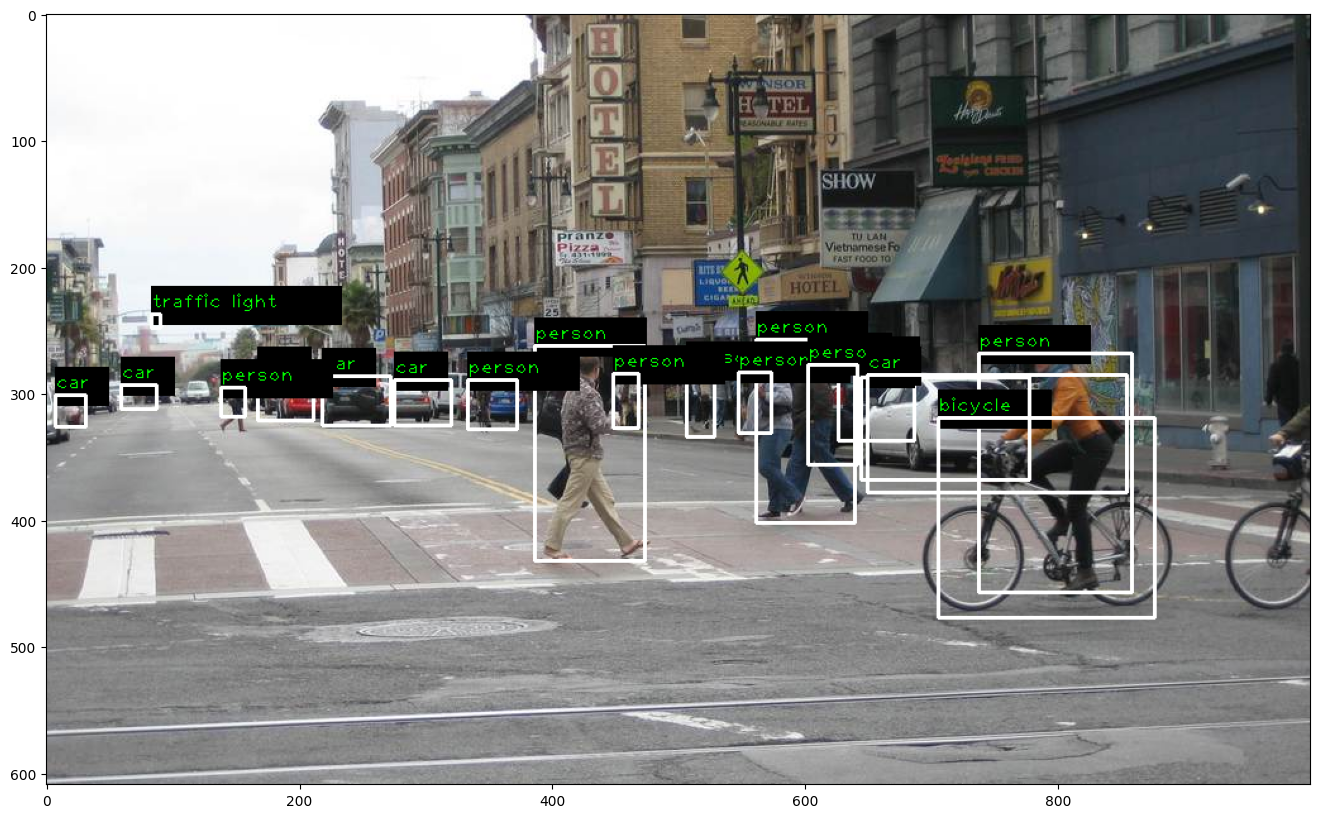

In [28]:
im = cv2.imread("images/street.jpg")
objects = detect_objects(net,im)
display_objects(im,objects)